In [7]:
%matplotlib inline
import numpy as np

# plotting tools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib

# units
from astropy import units as u
from astropy.io import fits

# POPPY
import poppy
from poppy.poppy_core import PlaneType

# Import external functions file; mostly pulled from magaox_poppy
import LGS_calc as lgs

# print version running of POPPY
poppy.__version__

'0.8.1dev1324.dev1324'

## Initiate the optical elements and variables

### Assumptions made:
- Deformable mirrors (Iris AO) are implemented as perfect surface flat mirrors using POPPY's built-in functions.

In [2]:
# define calculation parameters
oversamp = 0.125
samp = 256

# Wavelengths used on testbed
wavelength = {'LGS': 632.8e-9*u.m, 'tgt': 531e-9*u.m}

# Testbed parameters
space_parms = {'LUVOIR_diam': 15 * u.m, 'LGS_dist': 5e7 * u.m, 'LGS_sep': 20*u.arcsec}

# Compile the LGS system prescription
rx_LGS = lgs.makeRxCSV('data/rxCSV/rx_LGS.csv')

# Choosing important information
for t_optic, test_opt in enumerate(rx_LGS):
    if test_opt['Name'] == 'IrisAO-map':
        irisAO_radius = test_opt['Radius_m'] * u.m
        irisAO_index = test_opt['Optical_Element_Number']
    elif test_opt['Name'] == 'OAP-2':
        OAP_fl = test_opt['Focal_Length_m'] * u.m
    elif test_opt['Name'] == 'ZWFS-opd':
        ZWFS_index = test_opt['Optical_Element_Number']

CSV file name: data/rxCSV/rx_LGS.csv
The names of the headers are:
('Optical_Element_Number', 'Name', 'Type', 'Focal_Length_m', 'Distance_m', 'Radius_m', 'surf_PSD_folder', 'surf_PSD_filename', 'optic_type', 'OPD_unit', 'Correction_m', 'Comment')


Build the IrisAO DM map. Declare here any segment actuator states.

The IrisAO DM map won't be needed when building ZWFS, but it is needed when passing into csvFresnel. It will be needed when the system is built again with the ZWFS in place.

In [3]:
# Build the IrisAO DM map
hexdm = poppy.dms.HexSegmentedDeformableMirror(name='IrisAO PTT111L', rings=3, flattoflat=1212.4e-6*u.m, gap=7e-6*u.m, center=True)
#hexdm.set_actuator(12, 0.5*u.micron, 0, 0)
#hexdm.set_actuator(18, -0.25*u.micron, 0, 0)
#hexdm.set_actuator(6, 0, -0.25*u.microradian, 0)

Building the ZWFS mask based on an off-axis LGS source with no segmented DM in place. This is done so we can calculate the pixel scaling at the ZWFS focal plane to correctly form the ZWFS mask.

In [4]:
# Declaring ZWFS parameters
zwfs_parms = {}
zwfs_parms['fnum'] = OAP_fl / (irisAO_radius*2)
zwfs_parms['platescale'] = (206265 * u.arcsec) / (irisAO_radius * 2 * zwfs_parms['fnum'])
zwfs_parms['sep'] =  space_parms['LGS_sep'] / zwfs_parms['platescale'] # PSF separation [meters]

# Calculating LGS off-axis finite distance aberrations
LGS_coeff_sequence = lgs.ZWFEcoeff_LGS(space_parms, wavelength['LGS'], irisAO_radius)
# Choose this if removing defocus
LGS_coeff_sequence[3] = 0 # push out defocus for now for proof of concepts

ValueError: Argument 'wavelength' to function '__init__' must be a number (not 'Wavefront:
        wavelength = 0.6328 micron
        shape = (2048, 2048)
        sampling = 1.76171875e-05 m / pix'), and convertable to units='m'.

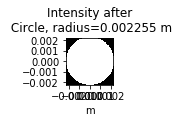

In [6]:
# Build testbed with off-axis LGS, but no DM present
# This is done so the pixel scaling at the ZWFS focal plane can be determined.
lgstb = lgs.csvFresnel(rx_csv=rx_LGS, samp=samp, oversamp=oversamp, axis='LGS', break_plane='FP2', 
                       source_ZWFE_coeff=LGS_coeff_sequence, irisAOmap=hexdm, irisAOstatus=False)
fp_psf = lgstb.calc_psf(wavelength=wavelength['LGS'], 
                                        display_intermediates=True, 
                                        return_intermediates=True, save_intermediates=False)

In [ ]:
# Collect the data at the ZWFS focal plane
zwfs_parms['pixscale'] = fp_wfs[-1].pixelscale

# Add in ZWFS pixel dimensions 
zwfs_parms['diam_pix'] = zwfs_parms['diam']/zwfs_parms['pixscale']

# Padding factor for getting the shift correct with POPPY's commands
zwfs_parms['pad_factor'] = (samp/oversamp/2)*u.pix/(zwfs_parms['diam_pix']/2)

# Calculate the size of ZWFS diameter based on Mamadou's efficiency
zwfs_parms['diam'] = 1.06 * wavelength['LGS'] * OAP_fl / (irisAO_radius*2)

# Calculate the PSF tilt displacement
lgs_psf_tilt = zwfs_parms['sep']/lgs.calcZernikeNormCoeff('tilt')

# Assemble the ZWFS mask
zwfs_ap = poppy.CircularAperture(radius=zwfs_parms['diam']/2,name="ZWFS aperture", 
                                 pad_factor=zwfs_parms['pad_factor'])
zwfs_ap.shift_y = lgs_psf_tilt.value
zwfs_ap.shift_x = 0 # No shift along X, will change if using tip.
zwfs_data = zwfs_ap.to_fits(npix=np.int_(samp/oversamp))[0].data
zwfs_opd_surf_data = (wavelength['LGS'].value/(2*np.pi))*zwfs_data*(np.pi/2)
# passing in meters? looks like it.
zwfs_opd_filename = 'zwfs_opd1'
mf.writeOPDfile(zwfs_opd_surf_data, zwfs_parms['pixscale'].value, 'data/' + zwfs_opd_filename + '.fits')

In [ ]:
# incorporate ZWFS into the prescription data
rx_LGS['surf_PSD_filename'][ZWFS_index] = zwfs_opd_filename

# Rebuild to ZWFS pupil image with ZWFS mask inserted into system
lgstb = lgs.csvFresnel(rx_csv=rx_LGS, samp=samp, oversamp=oversamp, axis='LGS', break_plane='imgZWFS', 
                       source_ZWFE_coeff=LGS_coeff_sequence, irisAOmap=hexdm, irisAOstatus=True)
zwfs_psf, zwfs_wfs = lgstb.calc_psf(wavelength=wavelength['LGS'].value, 
                                        display_intermediates=True, 
                                        return_intermediates=True, save_intermediates=False)